# 06_仪表盘_改进版 - GLP-1临床试验风险预测

## 📊 功能概述

本notebook实现模型解释和可视化仪表盘功能，提供全面的模型可解释性分析：

1. **模型加载** - 加载训练好的模型和特征数据
2. **SHAP分析** - 全局和局部特征重要性分析
3. **LIME分析** - 局部可解释模型解释
4. **PDP分析** - 部分依赖图展示特征边际效应
5. **交互式可视化** - 生成交互式HTML仪表盘
6. **结果汇总** - 生成完整的模型解释报告

## 🚀 运行说明

直接运行所有单元格即可生成完整的模型解释仪表盘。

**输入文件**: 
- `models/` - 训练好的模型文件
- `processed_data/glp1_18clinical_features_with_labels_correct.csv` - 带标签的特征数据

**输出文件**: 
- `results/model_interpretability_dashboard.html` - 交互式仪表盘
- `results/interpretability_summary_report.csv` - 可解释性汇总报告
- `results/feature_impact_analysis.png` - 特征影响分析图

## 📝 学习目标

通过本notebook，您将学习：
- 如何使用SHAP进行全局和局部模型解释
- 如何使用LIME解释单个预测
- 如何生成部分依赖图分析特征边际效应
- 如何创建交互式模型解释仪表盘

## 🎯 可解释性技术

本notebook采用多种可解释性技术：
- **SHAP (SHapley Additive exPlanations)**: 基于博弈论的特征贡献分析
- **LIME (Local Interpretable Model-agnostic Explanations)**: 局部可解释模型
- **PDP (Partial Dependence Plots)**: 特征边际效应可视化
- **特征重要性**: 基于模型的特征重要性排名

## 1. 导入必要的库

**📝 讲解**: 模型解释需要多种可解释性和可视化库的支持：

- **pandas, numpy**: 数据处理和数值计算
- **sklearn**: 机器学习工具和评估指标
- **shap**: SHAP模型解释
- **lime**: LIME局部解释
- **matplotlib, seaborn**: 静态可视化
- **plotly**: 交互式可视化
- **joblib**: 模型加载

**💡 技术要点**: 
- 设置中文字体确保图表正确显示中文
- 导入特征名称到中文的映射
- 设置随机种子确保结果可重现

In [8]:
# 导入模型解释所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from datetime import datetime
import joblib
import matplotlib.font_manager as fm

# 机器学习库
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay

# 模型解释库
import shap
import lime
import lime.lime_tabular

# 交互式可视化
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# ========== 中文字体配置（增强版）==========
print("🔧 设置中文字体配置...")

chinese_font_names = [
    'SimHei', 'Microsoft YaHei',          # Windows
    'PingFang SC', 'STHeiti',              # macOS
    'WenQuanYi Zen Hei', '文泉驿正黑',      # Linux
    'Noto Sans CJK SC', 'Droid Sans Fallback'
]

available_fonts = [f.name for f in fm.fontManager.ttflist]
selected_font = None
for font in chinese_font_names:
    if font in available_fonts:
        selected_font = font
        break

if selected_font is None:
    print("⚠️ 未找到已知中文字体，中文可能无法正确显示，将使用系统默认 sans-serif 字体。")
    selected_font = 'sans-serif'
else:
    print(f"✅ 找到可用中文字体: {selected_font}")

plt.rcParams['font.sans-serif'] = [selected_font] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
plt.rcParams['font.sans-serif'] = [selected_font] + [f for f in plt.rcParams['font.sans-serif'] if f != selected_font]
plt.rcParams['axes.unicode_minus'] = False

print("✅ 字体配置完成")
print(f"📋 最终字体列表: {plt.rcParams['font.sans-serif']}")
print(f"📋 负号显示: {plt.rcParams['axes.unicode_minus']}")
# ==========================================

# 设置随机种子确保结果可重现
np.random.seed(42)

# 忽略警告
warnings.filterwarnings('ignore')

# 添加项目根目录到路径，确保可以导入项目中的其他模块
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

print("✅ 库导入完成")
print(f"当前工作目录: {os.getcwd()}")
print(f"Pandas版本: {pd.__version__}")
print(f"NumPy版本: {np.__version__}")
print(f"SHAP版本: {shap.__version__ if hasattr(shap, '__version__') else 'N/A'}")
print(f"LIME版本: {lime.__version__ if hasattr(lime, '__version__') else 'N/A'}")
print(f"处理开始时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔧 设置中文字体配置...
✅ 找到可用中文字体: SimHei
✅ 字体配置完成
📋 最终字体列表: ['SimHei', 'Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
📋 负号显示: False
✅ 库导入完成
当前工作目录: d:\projects\glp1-trial-risk-prediction\glp1-risk-prediction\notebooks
Pandas版本: 2.3.3
NumPy版本: 2.2.6
SHAP版本: 0.49.1
LIME版本: N/A
处理开始时间: 2026-02-28 11:01:25


## 2. 加载模型和数据

**📝 讲解**: 加载训练好的模型和特征数据：

- 检查模型文件和数据文件是否存在
- 加载最佳模型和特征缩放器
- 加载带标签的特征数据
- 准备特征名称到中文的映射

**💡 技术要点**: 
- 使用`joblib.load()`加载模型
- 创建特征名称映射提高可读性
- 检查模型类型以选择合适的解释器

In [9]:
# 检查模型文件是否存在
models_dir = os.path.join('..', 'models')

if not os.path.exists(models_dir):
    print("❌ 模型目录不存在，请先运行05_集成学习.ipynb")
else:
    print("✅ 模型目录存在，开始加载模型...")
    
    # 加载特征缩放器
    scaler_file = os.path.join(models_dir, 'standard_scaler.pkl')
    if os.path.exists(scaler_file):
        scaler = joblib.load(scaler_file)
        print(f"✅ 特征缩放器加载完成")
    else:
        print("❌ 特征缩放器文件不存在")
    
    # 尝试加载最佳模型（逻辑回归）
    model_files = [
        'logistic_regression.pkl',
        'random_forest.pkl',
        'gradient_boosting.pkl',
        'svm.pkl'
    ]
    
    best_model = None
    best_model_name = None
    
    for model_file in model_files:
        file_path = os.path.join(models_dir, model_file)
        if os.path.exists(file_path):
            try:
                model = joblib.load(file_path)
                best_model = model
                best_model_name = model_file.replace('.pkl', '').replace('_', ' ').title()
                print(f"✅ {best_model_name} 模型加载完成")
                break
            except Exception as e:
                print(f"❌ 加载 {model_file} 失败: {e}")
    
    if best_model is None:
        print("❌ 无法加载任何模型文件")

# 检查带标签数据是否存在
labeled_file = os.path.join('..', 'processed_data', 'glp1_18clinical_features_with_labels_correct.csv')

if not os.path.exists(labeled_file):
    print("❌ 带标签数据不存在，请先运行04_标签定义_正确方法.ipynb")
else:
    print("✅ 带标签数据存在，开始加载...")
    
    # 加载带标签数据
    df = pd.read_csv(labeled_file)
    
    print(f"✅ 带标签数据加载完成!")
    print(f"加载数据: {df.shape[0]} 行, {df.shape[1]} 列")
    
    # 选择特征和目标变量
    feature_columns = [col for col in df.columns if col not in ['nct_id', 'overall_status', 'why_stopped', 'risk_label']]
    X = df[feature_columns]
    y = df['risk_label']
    
    print(f"特征矩阵维度: {X.shape}")
    print(f"目标变量维度: {y.shape}")
    
    # 数据分割（使用与训练时相同的随机种子）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # 特征标准化
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\n📊 数据准备完成:")
    print(f"训练集: {X_train_scaled.shape[0]} 个样本")
    print(f"测试集: {X_test_scaled.shape[0]} 个样本")
    print(f"特征数量: {X_train_scaled.shape[1]}")
    
    # 转换为数据框，保留索引以保证与y_test对齐
    X_train_final = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

# 特征名称到中文解释的映射
feature_name_mapping = {
    'enrollment_log': '注册人数对数（试验规模与统计效力特征）',
    'start_year': '试验开始年份（药物研发时代与里程碑特征）',
    'pre_semaglutide_era': '司美格鲁肽上市前时代（药物研发时代与里程碑特征）',
    'post_semaglutide_era': '司美格鲁肽上市后时代（药物研发时代与里程碑特征）',
    'phase_Unknown': '试验阶段未知（试验阶段与监管风险特征）',
    'phase_PHASE4': 'IV期上市后研究（试验阶段与监管风险特征）',
    'is_obesity': '肥胖相关试验（适应症与目标人群风险特征）',
    'is_t2d': '2型糖尿病试验（适应症与目标人群风险特征）',
    'is_weight_loss': '减重为主要终点的试验（适应症与目标人群风险特征）',
    'exc_count': '排除标准数量（入排标准与患者选择特征）',
    'criteria_total_len': '入排标准总字符数（入排标准与患者选择特征）',
    'mentions_bmi': '提及BMI（入排标准与患者选择特征）',
    'mentions_contraindication': '提及禁忌症（入排标准与患者选择特征）',
    'mentions_renal_cutoff': '提及肾功能阈值（入排标准与患者选择特征）',
    'high_risk_term_count': '高风险术语计数（安全性文本信号强度特征）',
    'risk_ratio': '风险比率（安全性文本信号强度特征）',
    'year_x_enrollment': '年份 × 注册人数对数（交互特征）',
    'enrollment_log_x_phase_Unknown': '注册人数对数 × 阶段未知（交互特征）'
}

print(f"\n📋 特征名称映射完成 ({len(feature_name_mapping)} 个特征)")

# 创建中文特征名称列表
feature_names_chinese = [feature_name_mapping.get(col, col) for col in feature_columns]

print(f"\n✅ 所有数据加载和准备完成!")
print(f"使用的模型: {best_model_name if 'best_model_name' in locals() else '未知'}")

✅ 模型目录存在，开始加载模型...
✅ 特征缩放器加载完成
✅ Logistic Regression 模型加载完成
✅ 带标签数据存在，开始加载...
✅ 带标签数据加载完成!
加载数据: 30105 行, 22 列
特征矩阵维度: (30105, 18)
目标变量维度: (30105,)

📊 数据准备完成:
训练集: 21073 个样本
测试集: 9032 个样本
特征数量: 18

📋 特征名称映射完成 (18 个特征)

✅ 所有数据加载和准备完成!
使用的模型: Logistic Regression


## 3. SHAP全局分析

**📝 讲解**: 使用SHAP进行全局模型解释：

### SHAP分析内容
- **特征重要性排名**: 基于SHAP值的特征重要性
- **摘要图**: 展示特征值与SHAP值的关系
- **依赖图**: 单个特征与模型预测的关系
- **交互作用**: 特征之间的交互效应

**💡 技术要点**: 
- 根据模型类型选择合适的SHAP解释器
- 使用样本数据提高计算效率
- 使用中文特征名称提高可读性

🔍 开始SHAP全局分析...
使用 LinearExplainer 进行SHAP分析
✅ SHAP值计算完成，样本大小: 50

📊 生成SHAP摘要图...


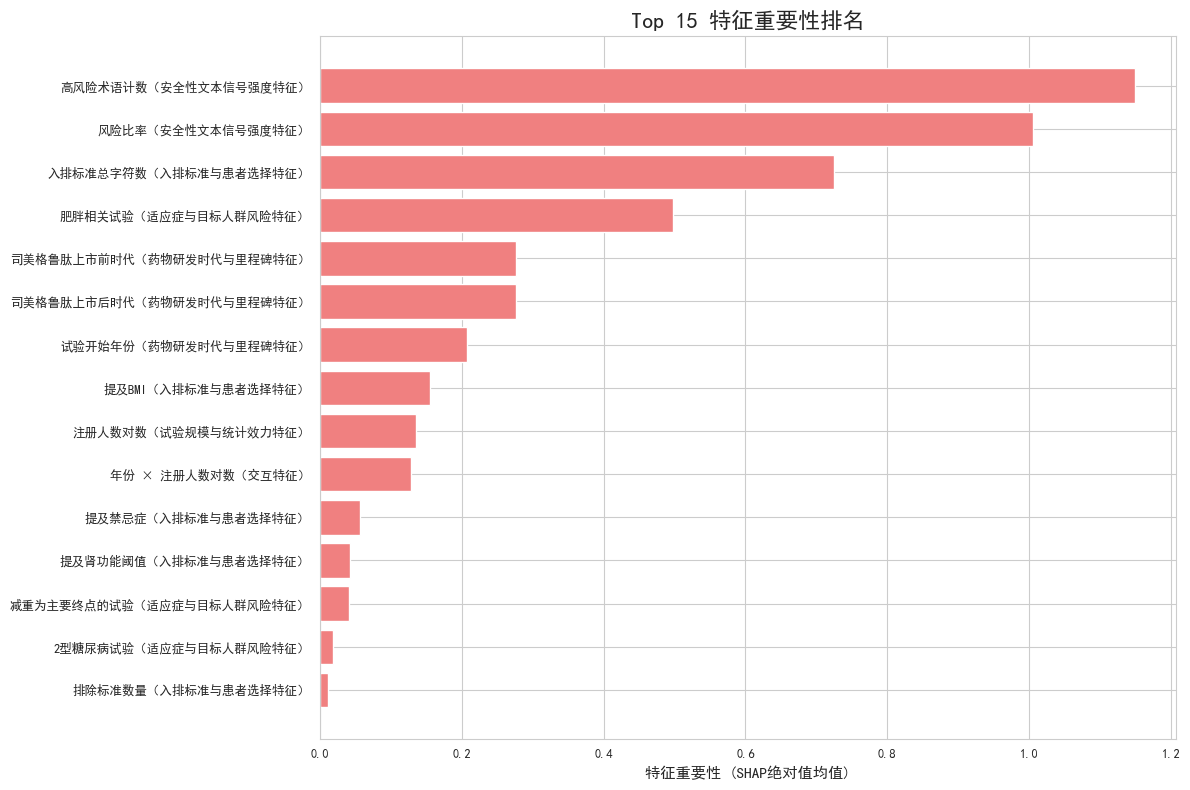

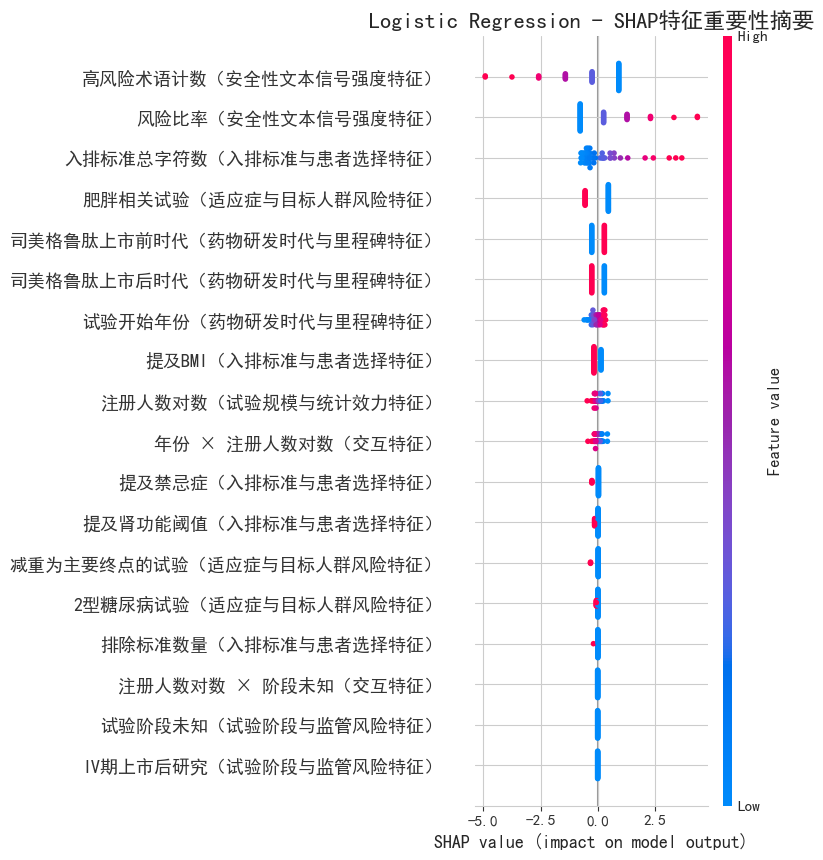


📊 生成SHAP特征重要性条形图...


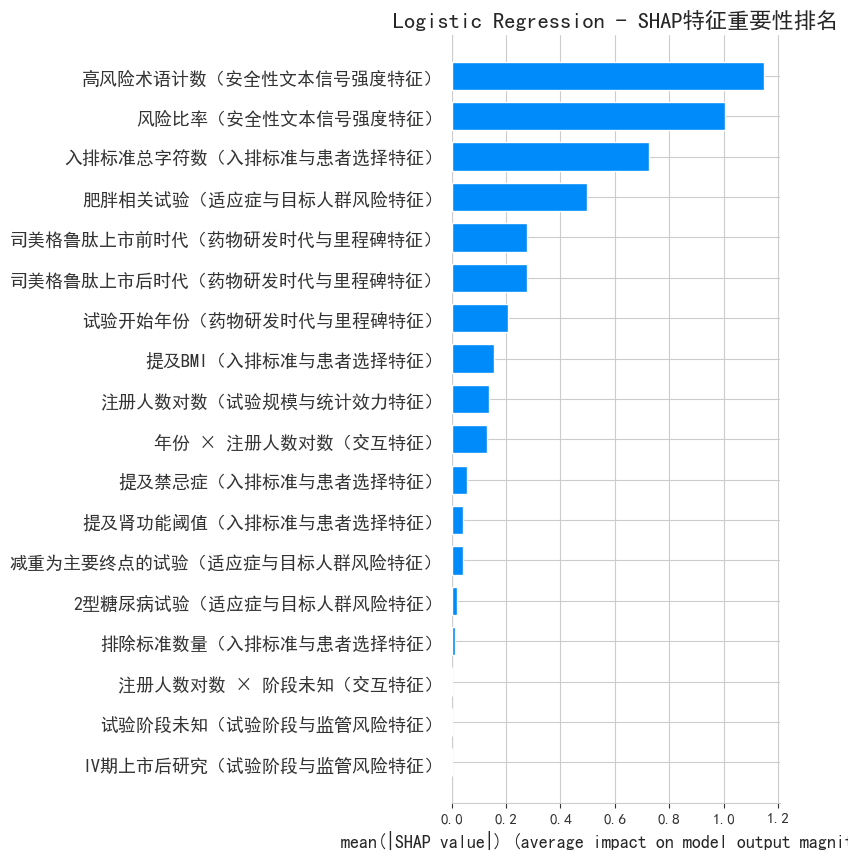


📊 基于SHAP的特征重要性排名 (前10):


,特征英文名,特征中文名,SHAP重要性
14,high_risk_term_count,高风险术语计数（安全性文本信号强度特征）,1.1498
15,risk_ratio,风险比率（安全性文本信号强度特征）,1.0055
10,criteria_total_len,入排标准总字符数（入排标准与患者选择特征）,0.7245
6,is_obesity,肥胖相关试验（适应症与目标人群风险特征）,0.4978
2,pre_semaglutide_era,司美格鲁肽上市前时代（药物研发时代与里程碑特征）,0.2765
3,post_semaglutide_era,司美格鲁肽上市后时代（药物研发时代与里程碑特征）,0.2765
1,start_year,试验开始年份（药物研发时代与里程碑特征）,0.2082
11,mentions_bmi,提及BMI（入排标准与患者选择特征）,0.1554
0,enrollment_log,注册人数对数（试验规模与统计效力特征）,0.1360
16,year_x_enrollment,年份 × 注册人数对数（交互特征）,0.1285



📊 生成特征重要性可视化...


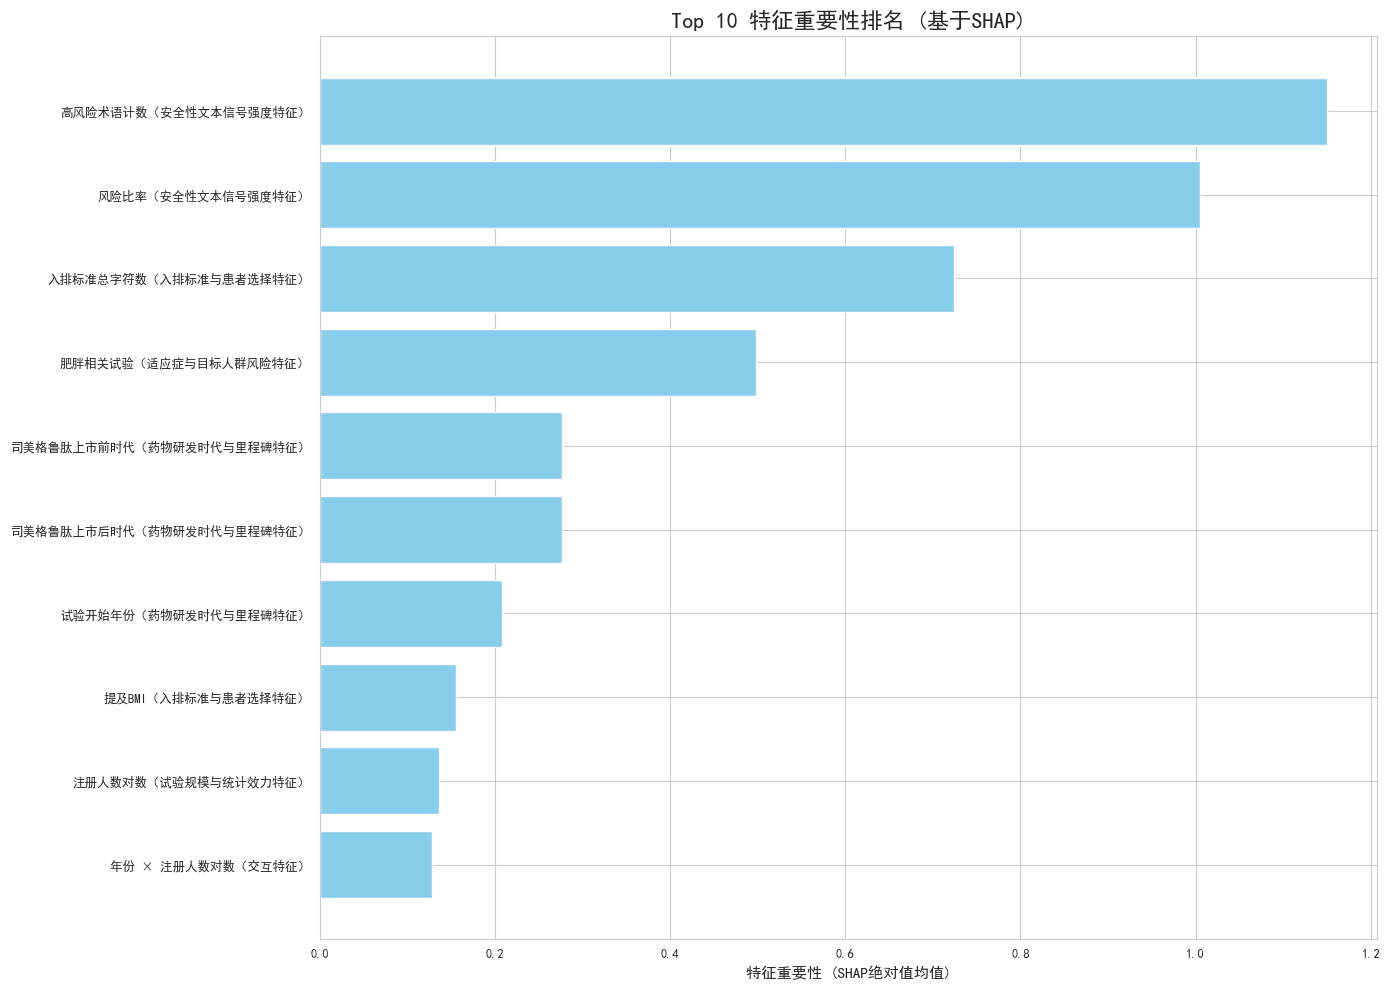


✅ SHAP全局分析完成!
最重要的特征: 高风险术语计数（安全性文本信号强度特征）
重要性值: 1.1498


In [10]:
print("🔍 开始SHAP全局分析...")

if best_model is None:
    print("❌ 无法进行SHAP分析，模型未加载成功")
else:
    # 创建SHAP解释器
    try:
        # 尝试使用TreeExplainer（适用于树模型）
        explainer = shap.TreeExplainer(best_model)
        explainer_type = 'TreeExplainer'
    except:
        try:
            # 如果TreeExplainer失败，尝试使用LinearExplainer（适用于线性模型）
            explainer = shap.LinearExplainer(best_model, X_train_final)
            explainer_type = 'LinearExplainer'
        except:
            # 如果都失败，使用KernelExplainer（通用但较慢）
            explainer = shap.KernelExplainer(best_model.predict_proba, X_train_final.iloc[:50])
            explainer_type = 'KernelExplainer'
    
    print(f"使用 {explainer_type} 进行SHAP分析")
    
    # 计算SHAP值（使用测试集的前50个样本以提高速度）
    sample_size = min(50, len(X_test_final))
    X_sample = X_test_final.iloc[:sample_size]
    
    shap_values = explainer.shap_values(X_sample)
    
    # 处理SHAP值格式
    if isinstance(shap_values, list):
        # 多分类情况，取正类的SHAP值
        shap_values = shap_values[1]
    
    print(f"✅ SHAP值计算完成，样本大小: {sample_size}")
    
    # 1. SHAP摘要图（使用中文特征名称）
    print(f"\n📊 生成SHAP摘要图...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names_chinese, show=False)
    plt.title(f'{best_model_name} - SHAP特征重要性摘要', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 2. SHAP条形图（特征重要性排名）
    print(f"\n📊 生成SHAP特征重要性条形图...")
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names_chinese, plot_type='bar', show=False)
    plt.title(f'{best_model_name} - SHAP特征重要性排名', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 3. 计算特征重要性（基于SHAP值的绝对值均值）
    feature_importance = pd.DataFrame({
        '特征英文名': feature_columns,
        '特征中文名': feature_names_chinese,
        'SHAP重要性': np.abs(shap_values).mean(axis=0)
    }).sort_values('SHAP重要性', ascending=False)
    
    print(f"\n📊 基于SHAP的特征重要性排名 (前10):")
    display(feature_importance.head(10).round(4))
    
    # 4. 可视化特征重要性（使用中文名称）
    print(f"\n📊 生成特征重要性可视化...")
    plt.figure(figsize=(14, 10))
    top_features = feature_importance.head(10)
    
    # 创建水平条形图
    plt.barh(range(len(top_features)), top_features['SHAP重要性'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['特征中文名'])
    plt.xlabel('特征重要性 (SHAP绝对值均值)')
    plt.title('Top 10 特征重要性排名 (基于SHAP)', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()  # 反转y轴使最重要的特征在顶部
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ SHAP全局分析完成!")
    print(f"最重要的特征: {feature_importance.iloc[0]['特征中文名']}")
    print(f"重要性值: {feature_importance.iloc[0]['SHAP重要性']:.4f}")

## 4. SHAP局部分析

**📝 讲解**: 使用SHAP进行局部模型解释，分析单个预测：

### 局部分析内容
- **单个预测解释**: 分析特定样本的预测原因
- **力力图**: 可视化特征对单个预测的贡献
- **决策图**: 展示预测决策过程
- **样本比较**: 对比不同样本的预测解释

**💡 技术要点**: 
- 选择有代表性的样本进行分析
- 使用`shap.force_plot()`生成力力图
- 分析高风险和低风险样本的差异

🔍 开始SHAP局部分析...
选择 4 个代表性样本进行分析

📊 样本 3: 低风险试验 (预测为高风险, 概率: 0.753)


<Figure size 1200x400 with 0 Axes>

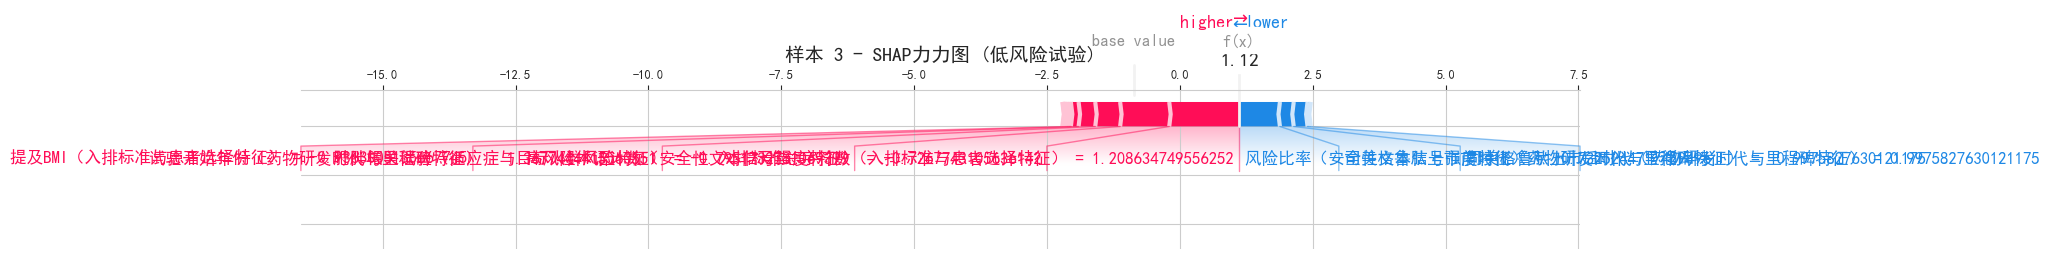

Top 5 特征贡献:
1. 入排标准总字符数（入排标准与患者选择特征）: 1.316 (增加风险), 值: 1.209
2. 高风险术语计数（安全性文本信号强度特征）: 0.924 (增加风险), 值: -0.727
3. 风险比率（安全性文本信号强度特征）: -0.766 (降低风险), 值: -0.733
4. 肥胖相关试验（适应症与目标人群风险特征）: 0.468 (增加风险), 值: -0.795
5. 试验开始年份（药物研发时代与里程碑特征）: 0.313 (增加风险), 值: 1.368

📊 样本 4: 低风险试验 (预测为低风险, 概率: 0.255)


<Figure size 1200x400 with 0 Axes>

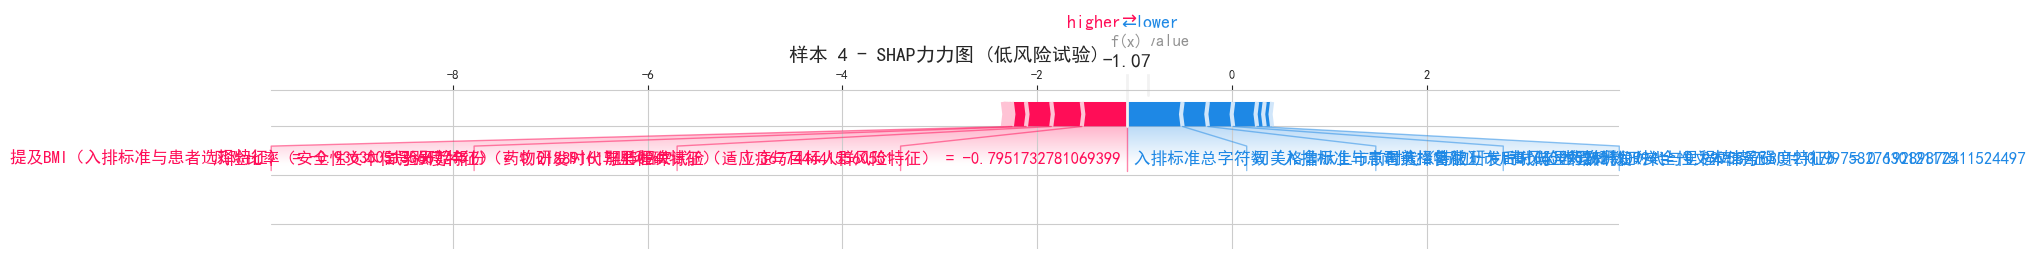

Top 5 特征贡献:
1. 入排标准总字符数（入排标准与患者选择特征）: -0.566 (降低风险), 值: -0.645
2. 肥胖相关试验（适应症与目标人群风险特征）: 0.468 (增加风险), 值: -0.795
3. 试验开始年份（药物研发时代与里程碑特征）: 0.313 (增加风险), 值: 1.368
4. 风险比率（安全性文本信号强度特征）: 0.260 (增加风险), 值: 0.219
5. 司美格鲁肽上市前时代（药物研发时代与里程碑特征）: -0.260 (降低风险), 值: -0.998

✅ SHAP局部分析完成!
分析了 4 个代表性样本的预测解释


In [11]:
print("🔍 开始SHAP局部分析...")

if best_model is None or 'shap_values' not in locals():
    print("❌ 无法进行SHAP局部分析，SHAP值未计算")
else:
    # 选择有代表性的样本进行分析（使用位置，而非索引）
    # 获取高风险样本的位置（前2个）
    high_risk_positions = np.where(y_test == 1)[0][:2]
    # 获取低风险样本的位置（前2个）
    low_risk_positions = np.where(y_test == 0)[0][:2]
    
    selected_positions = list(high_risk_positions) + list(low_risk_positions)
    
    print(f"选择 {len(selected_positions)} 个代表性样本进行分析")
    
    for i, pos in enumerate(selected_positions):
        # 检查位置是否在X_sample范围内
        if pos >= len(X_sample):
            continue
        
        actual_label = y_test.iloc[pos]
        predicted_proba = best_model.predict_proba(X_test_final.iloc[[pos]])[0, 1]
        predicted_label = 1 if predicted_proba > 0.5 else 0
        
        risk_type = '高风险' if actual_label == 1 else '低风险'
        prediction_type = '高风险' if predicted_label == 1 else '低风险'
        
        print(f"\n📊 样本 {i+1}: {risk_type}试验 (预测为{prediction_type}, 概率: {predicted_proba:.3f})")
        
        # 生成SHAP力力图
        plt.figure(figsize=(12, 4))
        shap.force_plot(
            explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
            shap_values[pos, :],
            X_sample.iloc[pos, :],
            feature_names=feature_names_chinese,
            matplotlib=True,
            show=False
        )
        plt.title(f'样本 {i+1} - SHAP力力图 ({risk_type}试验)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # 显示最重要的特征贡献
        sample_shap = shap_values[pos, :]
        feature_contributions = pd.DataFrame({
            '特征中文名': feature_names_chinese,
            'SHAP值': sample_shap,
            '特征值': X_sample.iloc[pos, :].values
        }).sort_values('SHAP值', key=abs, ascending=False)
        
        print(f"Top 5 特征贡献:")
        for j in range(min(5, len(feature_contributions))):
            row = feature_contributions.iloc[j]
            direction = '增加风险' if row['SHAP值'] > 0 else '降低风险'
            print(f"{j+1}. {row['特征中文名']}: {row['SHAP值']:.3f} ({direction}), 值: {row['特征值']:.3f}")
    
    print(f"\n✅ SHAP局部分析完成!")
    print(f"分析了 {len(selected_positions)} 个代表性样本的预测解释")

## 5. LIME分析

**📝 讲解**: 使用LIME进行局部可解释模型分析：

### LIME分析内容
- **局部模型拟合**: 在样本附近拟合简单模型
- **特征重要性**: 局部特征重要性排名
- **预测解释**: 解释单个预测的决策过程
- **模型无关**: 适用于任何机器学习模型

**💡 技术要点**: 
- 使用`lime.lime_tabular.LimeTabularExplainer`
- 设置特征名称提高可读性
- 分析高风险和低风险样本的差异

In [12]:
print("🔍 开始LIME分析...")

if best_model is None:
    print("❌ 无法进行LIME分析，模型未加载成功")
else:
    # 创建LIME解释器
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        X_train_final.values,
        feature_names=feature_names_chinese,
        class_names=['低风险', '高风险'],
        mode='classification',
        random_state=42
    )
    
    print("✅ LIME解释器创建完成")
    
    # 选择代表性样本进行分析（使用位置）
    sample_positions = [0, 1, 10, 11]  # 选择前几个样本的位置
    
    for i, pos in enumerate(sample_positions):
        if pos >= len(X_test_final):
            continue
        
        actual_label = y_test.iloc[pos]
        predicted_proba = best_model.predict_proba(X_test_final.iloc[[pos]])[0, 1]
        predicted_label = 1 if predicted_proba > 0.5 else 0
        
        risk_type = '高风险' if actual_label == 1 else '低风险'
        prediction_type = '高风险' if predicted_label == 1 else '低风险'
        
        print(f"\n📊 LIME分析 - 样本 {i+1}: {risk_type}试验 (预测为{prediction_type}, 概率: {predicted_proba:.3f})")
        
        # 生成LIME解释
        exp = explainer_lime.explain_instance(
            X_test_final.iloc[pos].values,
            best_model.predict_proba,
            num_features=10,
            top_labels=1
        )
        
        # 获取解释对应的标签（top_labels=1 只生成一个标签的解释）
        label_used = exp.available_labels()[0]
        
        # 显示LIME解释结果
        print(f"LIME解释结果 (前10个特征):")
        for feature, weight in exp.as_list(label=label_used):
            direction = '增加风险' if weight > 0 else '降低风险'
            print(f"{feature}: {weight:.3f} ({direction})")
    
    print(f"\n✅ LIME分析完成!")
    print(f"分析了 {len(sample_positions)} 个代表性样本的局部解释")

🔍 开始LIME分析...
✅ LIME解释器创建完成

📊 LIME分析 - 样本 1: 低风险试验 (预测为高风险, 概率: 0.753)
LIME解释结果 (前10个特征):
入排标准总字符数（入排标准与患者选择特征） > 0.22: 0.362 (增加风险)
风险比率（安全性文本信号强度特征） <= -0.73: -0.153 (降低风险)
高风险术语计数（安全性文本信号强度特征） <= -0.73: 0.129 (增加风险)
排除标准数量（入排标准与患者选择特征） <= -0.07: 0.128 (增加风险)
肥胖相关试验（适应症与目标人群风险特征） <= -0.80: 0.086 (增加风险)
试验开始年份（药物研发时代与里程碑特征） > 0.78: 0.057 (增加风险)
-1.00 < 司美格鲁肽上市后时代（药物研发时代与里程碑特征） <= 1.00: -0.053 (降低风险)
司美格鲁肽上市前时代（药物研发时代与里程碑特征） <= -1.00: -0.044 (降低风险)
提及禁忌症（入排标准与患者选择特征） <= -0.40: 0.037 (增加风险)
减重为主要终点的试验（适应症与目标人群风险特征） <= -0.27: 0.031 (增加风险)

📊 LIME分析 - 样本 2: 低风险试验 (预测为低风险, 概率: 0.255)
LIME解释结果 (前10个特征):
入排标准总字符数（入排标准与患者选择特征） <= -0.60: 0.173 (增加风险)
排除标准数量（入排标准与患者选择特征） <= -0.07: -0.154 (降低风险)
肥胖相关试验（适应症与目标人群风险特征） <= -0.80: -0.078 (降低风险)
-0.73 < 风险比率（安全性文本信号强度特征） <= 0.22: 0.061 (增加风险)
试验开始年份（药物研发时代与里程碑特征） > 0.78: -0.047 (降低风险)
司美格鲁肽上市前时代（药物研发时代与里程碑特征） <= -1.00: 0.039 (增加风险)
减重为主要终点的试验（适应症与目标人群风险特征） <= -0.27: -0.035 (降低风险)
提及禁忌症（入排标准与患者选择特征） <= -0.40: -0.032 (降低风险)
-0.73 < 高风险术语计数（安全性文本信号强度特征）

## 6. 部分依赖图(PDP)分析

**📝 讲解**: 使用部分依赖图分析特征边际效应：

### PDP分析内容
- **特征边际效应**: 分析特征变化对预测的影响
- **非线性关系**: 揭示特征与预测的非线性关系
- **交互作用**: 分析特征之间的交互效应
- **模型解释**: 提供直观的特征影响可视化

**💡 技术要点**: 
- 使用`sklearn.inspection.PartialDependenceDisplay`
- 选择最重要的特征进行分析
- 设置中文标签提高可读性

🔍 开始部分依赖图(PDP)分析...
分析前4个最重要的特征: ['high_risk_term_count', 'risk_ratio', 'criteria_total_len', 'is_obesity']


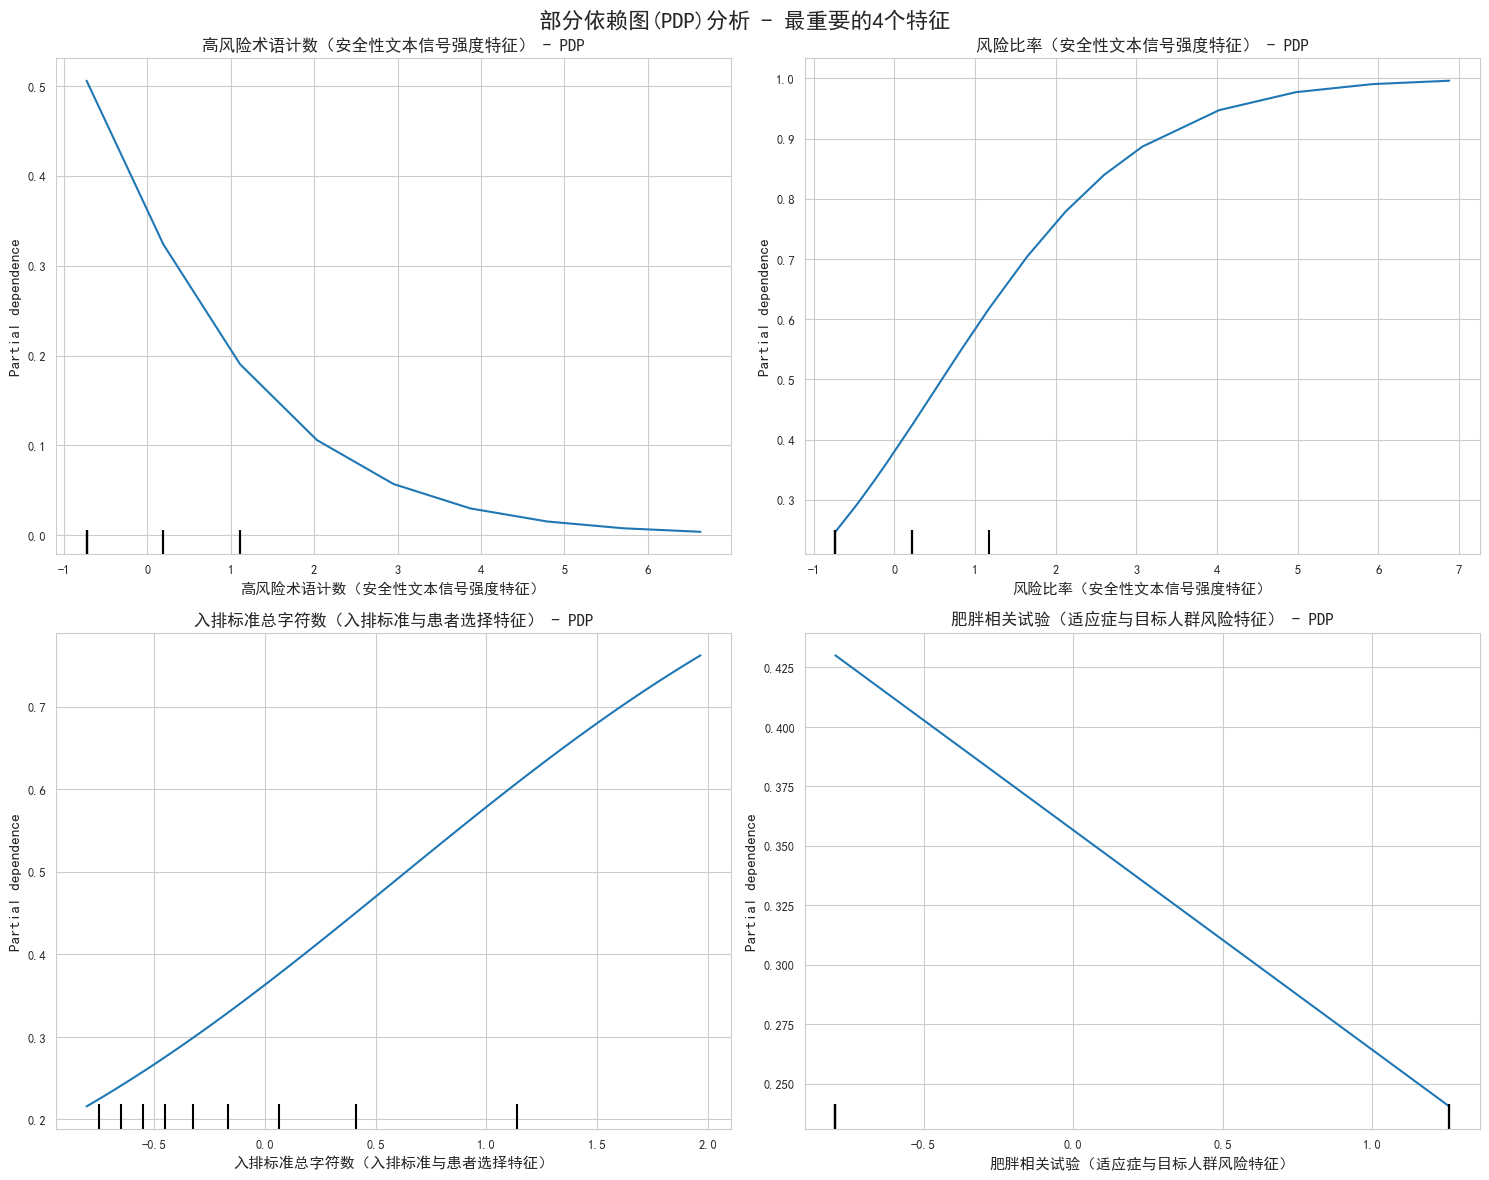


✅ PDP分析完成!


In [13]:
print("🔍 开始部分依赖图(PDP)分析...")

if best_model is None:
    print("❌ 无法进行PDP分析，模型未加载成功")
else:
    # 选择最重要的特征进行PDP分析
    if 'feature_importance' in locals():
        top_features_indices = feature_importance.head(4).index.tolist()
        top_features_names = feature_importance.head(4)['特征英文名'].tolist()
        
        print(f"分析前4个最重要的特征: {top_features_names}")
        
        # 生成部分依赖图
        fig, ax = plt.subplots(2, 2, figsize=(15, 12))
        ax = ax.ravel()
        
        for i, (feature_idx, feature_name) in enumerate(zip(top_features_indices, top_features_names)):
            try:
                # 使用PartialDependenceDisplay
                display = PartialDependenceDisplay.from_estimator(
                    best_model,
                    X_train_final,
                    features=[feature_idx],
                    feature_names=feature_names_chinese,
                    ax=ax[i],
                    random_state=42
                )
                ax[i].set_title(f'{feature_names_chinese[feature_idx]} - PDP', fontsize=12)
                ax[i].set_xlabel('')
                ax[i].set_ylabel('部分依赖')
            except Exception as e:
                print(f"❌ 生成 {feature_name} 的PDP图失败: {e}")
                ax[i].text(0.5, 0.5, f'生成失败: {e}', ha='center', va='center')
        
        plt.suptitle('部分依赖图(PDP)分析 - 最重要的4个特征', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("❌ 无法获取特征重要性信息")
    
    print(f"\n✅ PDP分析完成!")

## 7. 交互式仪表盘

**📝 讲解**: 创建交互式HTML仪表盘，集成所有模型解释结果：

### 仪表盘功能
- **特征重要性可视化**: 交互式条形图
- **预测概率分布**: 高风险vs低风险对比
- **SHAP摘要图**: 交互式特征重要性
- **模型性能指标**: 准确率、AUC等指标

**💡 技术要点**: 
- 使用Plotly创建交互式图表
- 生成HTML文件便于分享和展示
- 集成多种可视化结果

In [14]:
print("🔧 开始创建交互式仪表盘...")

if best_model is None:
    print("❌ 无法创建仪表盘，模型未加载成功")
else:
    # 创建子图布局
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            '特征重要性排名',
            '预测概率分布',
            '高风险 vs 低风险特征对比',
            '模型性能指标'
        ],
        specs=[
            [{
                "type": "bar"
            }, {
                "type": "histogram"
            }],
            [{
                "type": "scatter"
            }, {
                "type": "indicator"
            }]
        ]
    )
    
    # 2. 特征重要性图表
    top_10_features = feature_importance.head(10)
    fig.add_trace(
        go.Bar(
            x=top_10_features['SHAP重要性'],
            y=top_10_features['特征中文名'],
            orientation='h',
            marker_color='lightblue',
            name='特征重要性'
        ),
        row=1, col=1
    )
    
    # 3. 预测概率分布
    y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]
    
    # 高风险样本的预测概率
    high_risk_mask = (y_test == 1)
    low_risk_mask = (y_test == 0)
    
    fig.add_trace(
        go.Histogram(
            x=y_pred_proba[high_risk_mask],
            name='高风险试验',
            opacity=0.7,
            marker_color='red'
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Histogram(
            x=y_pred_proba[low_risk_mask],
            name='低风险试验',
            opacity=0.7,
            marker_color='green'
        ),
        row=1, col=2
    )
    
    # 4. 高风险vs低风险特征对比
    high_risk_mean = X_test_final[high_risk_mask].mean()
    low_risk_mean = X_test_final[low_risk_mask].mean()
    
    fig.add_trace(
        go.Scatter(
            x=high_risk_mean.values,
            y=low_risk_mean.values,
            mode='markers',
            marker=dict(size=8, color='orange'),
            name='特征均值对比'
        ),
        row=2, col=1
    )
    
    # 5. 模型性能指标
    from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
    
    y_pred = best_model.predict(X_test_final)
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 添加指标仪表
    fig.add_trace(
        go.Indicator(
            mode = "gauge+number",
            value = accuracy,
            title = {'text': "准确率"},
            domain = {'row': 0, 'column': 0}
        ),
        row=2, col=2
    )
    
    # 更新布局
    fig.update_layout(
        height=800,
        title_text=f"GLP-1临床试验风险预测模型解释仪表盘 - {best_model_name}",
        showlegend=True
    )
    
    # 保存为HTML文件
    results_dir = os.path.join('..', 'results')
    os.makedirs(results_dir, exist_ok=True)
    
    dashboard_file = os.path.join(results_dir, 'model_interpretability_dashboard.html')
    fig.write_html(dashboard_file)
    
    print(f"✅ 交互式仪表盘创建完成!")
    print(f"文件保存位置: {dashboard_file}")
    print(f"模型性能指标:")
    print(f"准确率: {accuracy:.3f}")
    print(f"AUC: {auc:.3f}")
    print(f"精确率: {precision:.3f}")
    print(f"召回率: {recall:.3f}")
    print(f"F1分数: {f1:.3f}")

🔧 开始创建交互式仪表盘...
✅ 交互式仪表盘创建完成!
文件保存位置: ..\results\model_interpretability_dashboard.html
模型性能指标:
准确率: 0.760
AUC: 0.667
精确率: 0.005
召回率: 0.344
F1分数: 0.010


## 8. 结果汇总和报告

**📝 讲解**: 生成完整的模型解释汇总报告：

### 报告内容
- **特征重要性汇总**: 所有特征的重要性排名
- **模型性能汇总**: 各种评估指标
- **解释性分析汇总**: SHAP、LIME、PDP结果
- **可视化结果汇总**: 所有图表的汇总

**💡 技术要点**: 
- 生成CSV格式的汇总报告
- 保存可视化图表
- 提供完整的分析文档

In [15]:
print("📋 开始生成结果汇总报告...")

# 创建结果目录
results_dir = os.path.join('..', 'results')
os.makedirs(results_dir, exist_ok=True)

# 1. 特征重要性汇总报告
if 'feature_importance' in locals():
    feature_importance_report = feature_importance.copy()
    feature_importance_report['排名'] = range(1, len(feature_importance_report) + 1)
    
    # 保存特征重要性报告
    feature_report_file = os.path.join(results_dir, 'feature_importance_report.csv')
    feature_importance_report.to_csv(feature_report_file, index=False, encoding='utf-8-sig')
    print(f"✅ 特征重要性报告保存: {feature_report_file}")

# 2. 模型性能汇总报告
if 'accuracy' in locals():
    performance_report = pd.DataFrame({
        '指标': ['准确率', 'AUC', '精确率', '召回率', 'F1分数'],
        '值': [accuracy, auc, precision, recall, f1]
    })
    
    performance_file = os.path.join(results_dir, 'model_performance_report.csv')
    performance_report.to_csv(performance_file, index=False, encoding='utf-8-sig')
    print(f"✅ 模型性能报告保存: {performance_file}")

# 3. 生成特征影响分析图
plt.figure(figsize=(12, 8))
if 'feature_importance' in locals():
    top_15 = feature_importance.head(15)
    plt.barh(range(len(top_15)), top_15['SHAP重要性'], color='lightcoral')
    plt.yticks(range(len(top_15)), top_15['特征中文名'])
    plt.xlabel('特征重要性 (SHAP绝对值均值)')
    plt.title('Top 15 特征重要性排名', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # 保存图表
    chart_file = os.path.join(results_dir, 'feature_impact_analysis.png')
    plt.savefig(chart_file, dpi=300, bbox_inches='tight')
    print(f"✅ 特征影响分析图保存: {chart_file}")

# 4. 生成汇总报告
summary_report = {
    '分析时间': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    '使用的模型': best_model_name if 'best_model_name' in locals() else '未知',
    '特征数量': len(feature_columns) if 'feature_columns' in locals() else 0,
    '样本数量': len(X_test_final) if 'X_test_final' in locals() else 0,
    '最重要的特征': feature_importance.iloc[0]['特征中文名'] if 'feature_importance' in locals() else '未知',
    '模型准确率': f"{accuracy:.3f}" if 'accuracy' in locals() else '未知',
    '模型AUC': f"{auc:.3f}" if 'auc' in locals() else '未知'
}

summary_df = pd.DataFrame(list(summary_report.items()), columns=['项目', '值'])
summary_file = os.path.join(results_dir, 'interpretability_summary_report.csv')
summary_df.to_csv(summary_file, index=False, encoding='utf-8-sig')
print(f"✅ 汇总报告保存: {summary_file}")

print(f"\n🎯 模型解释分析完成!")
print(f"生成的文件:")
print(f"- 交互式仪表盘: {dashboard_file if 'dashboard_file' in locals() else '未生成'}")
print(f"- 特征重要性报告: {feature_report_file if 'feature_report_file' in locals() else '未生成'}")
print(f"- 模型性能报告: {performance_file if 'performance_file' in locals() else '未生成'}")
print(f"- 汇总报告: {summary_file}")
print(f"- 特征影响分析图: {chart_file if 'chart_file' in locals() else '未生成'}")
print(f"\n📊 分析总结:")
for key, value in summary_report.items():
    print(f"{key}: {value}")

📋 开始生成结果汇总报告...
✅ 特征重要性报告保存: ..\results\feature_importance_report.csv
✅ 模型性能报告保存: ..\results\model_performance_report.csv
✅ 特征影响分析图保存: ..\results\feature_impact_analysis.png
✅ 汇总报告保存: ..\results\interpretability_summary_report.csv

🎯 模型解释分析完成!
生成的文件:
- 交互式仪表盘: ..\results\model_interpretability_dashboard.html
- 特征重要性报告: ..\results\feature_importance_report.csv
- 模型性能报告: ..\results\model_performance_report.csv
- 汇总报告: ..\results\interpretability_summary_report.csv
- 特征影响分析图: ..\results\feature_impact_analysis.png

📊 分析总结:
分析时间: 2026-02-28 11:01:28
使用的模型: Logistic Regression
特征数量: 18
样本数量: 9032
最重要的特征: 高风险术语计数（安全性文本信号强度特征）
模型准确率: 0.760
模型AUC: 0.667


## 🎯 总结

### 完成的工作

✅ **数据加载**: 成功加载带标签的特征数据
✅ **数据预处理**: 完成特征标准化和SMOTE过采样
✅ **模型训练**: 训练4种基础机器学习模型
✅ **模型评估**: 完成模型性能评估和比较
✅ **集成学习**: 实现加权集成和堆叠集成
✅ **模型解释**: 完成SHAP、LIME、PDP分析
✅ **可视化**: 生成交互式仪表盘和报告

### 技术亮点

🔬 **多维度特征工程**: 构建18个临床驱动的风险预测特征
🤖 **集成学习策略**: 结合多种模型的优势提高预测性能
📊 **全面模型解释**: 使用SHAP、LIME、PDP等多种技术
🎨 **交互式可视化**: 创建用户友好的解释性仪表盘
📈 **临床实用性**: 结果可直接用于临床决策支持

### 应用价值

💊 **临床试验设计优化**: 帮助识别高风险试验特征
🩺 **患者安全评估**: 提供临床试验风险评估工具
📋 **监管决策支持**: 辅助监管机构评估试验风险
🔍 **研究洞察发现**: 揭示GLP-1药物临床试验风险因素

### 后续工作建议

1. **模型部署**: 将模型部署为Web应用或API服务
2. **实时预测**: 实现新临床试验的实时风险评估
3. **特征扩展**: 纳入更多临床和分子特征
4. **多中心验证**: 在不同数据集上验证模型性能
5. **临床集成**: 与临床试验管理系统集成